# Speech Emotion Recognition

## Importing Libraries

In [ ]:
import pandas as pd
import numpy as np

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from IPython.display import Audio

import joblib
import warnings

# Suppress warnings for a cleaner output
warnings.filterwarnings("ignore")

## Reading data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
Ravdess = "/mnt/d/Datasets/SpeechEmotionRecognition/RAVDESS"
Hindi = "/mnt/d/Datasets/SpeechEmotionRecognition/HindiSER"
IndianAccentEnglish = "/mnt/d/Datasets/SpeechEmotionRecognition/IndianAccentEnglishSER"

In [3]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []

for dir in ravdess_directory_list:
    actor_path = os.path.join(Ravdess, dir)
    if os.path.isdir(actor_path):
        actor_files = os.listdir(actor_path)

        for file in actor_files:
            part = file.split('.')[0].split('-')

            try:
                file_emotion.append(int(part[2]))
                file_path.append(os.path.join(actor_path, file))
            except ValueError:
                continue

emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])

Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

emotion_map = {
    1: 'neutral', 2: 'calm', 3: 'happy', 4: 'sad', 5: 'angry', 6: 'fear', 7: 'disgust', 8: 'surprise'
}
Ravdess_df['Emotions'] = Ravdess_df['Emotions'].replace(emotion_map)

Ravdess_df.head()

Emotions                                               Path
0  neutral  /mnt/d/Datasets/SpeechEmotionRecognition/RAVDE...
1  neutral  /mnt/d/Datasets/SpeechEmotionRecognition/RAVDE...
2  neutral  /mnt/d/Datasets/SpeechEmotionRecognition/RAVDE...
3  neutral  /mnt/d/Datasets/SpeechEmotionRecognition/RAVDE...
4     calm  /mnt/d/Datasets/SpeechEmotionRecognition/RAVDE...

In [4]:
hindi_file_paths = []
hindi_labels = []

hindi_base_path = Hindi

for emotion in os.listdir(hindi_base_path):
    emotion_folder = os.path.join(hindi_base_path, emotion)
    if os.path.isdir(emotion_folder):
        for file in os.listdir(emotion_folder):
            if file.endswith(".wav"):
                hindi_file_paths.append(os.path.join(emotion_folder, file))
                hindi_labels.append(emotion.lower())  # use folder name as label

hindi_df = pd.DataFrame({"Path": hindi_file_paths, "Emotions": hindi_labels})
hindi_df.head()

Path Emotions
0  /mnt/d/Datasets/SpeechEmotionRecognition/Hindi...    angry
1  /mnt/d/Datasets/SpeechEmotionRecognition/Hindi...    angry
2  /mnt/d/Datasets/SpeechEmotionRecognition/Hindi...    angry
3  /mnt/d/Datasets/SpeechEmotionRecognition/Hindi...    angry
4  /mnt/d/Datasets/SpeechEmotionRecognition/Hindi...    angry

In [5]:
paths = []
emotions = []

for emotion_label in os.listdir(IndianAccentEnglish):
    emotion_folder = os.path.join(IndianAccentEnglish, emotion_label)
    if os.path.isdir(emotion_folder):
        for filename in os.listdir(emotion_folder):
            if filename.endswith(".wav"):
                file_path = os.path.join(emotion_folder, filename)
                paths.append(file_path)
                emotions.append(emotion_label.lower())

indian_eng_df = pd.DataFrame({"Path": paths, "Emotions": emotions})

indian_eng_df.head()

Path Emotions
0  /mnt/d/Datasets/SpeechEmotionRecognition/India...    angry
1  /mnt/d/Datasets/SpeechEmotionRecognition/India...    angry
2  /mnt/d/Datasets/SpeechEmotionRecognition/India...    angry
3  /mnt/d/Datasets/SpeechEmotionRecognition/India...    angry
4  /mnt/d/Datasets/SpeechEmotionRecognition/India...    angry

In [6]:
data_path = pd.concat([Ravdess_df, hindi_df, indian_eng_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

Emotions                                               Path
0  neutral  /mnt/d/Datasets/SpeechEmotionRecognition/RAVDE...
1  neutral  /mnt/d/Datasets/SpeechEmotionRecognition/RAVDE...
2  neutral  /mnt/d/Datasets/SpeechEmotionRecognition/RAVDE...
3  neutral  /mnt/d/Datasets/SpeechEmotionRecognition/RAVDE...
4     calm  /mnt/d/Datasets/SpeechEmotionRecognition/RAVDE...

In [7]:
data_path.value_counts(['Emotions'])

Emotions
angry       962
happy       952
fear        931
sad         927
neutral     906
disgust     592
surprise    592
calm        540
Name: count, dtype: int64

## Visualisation and EDA

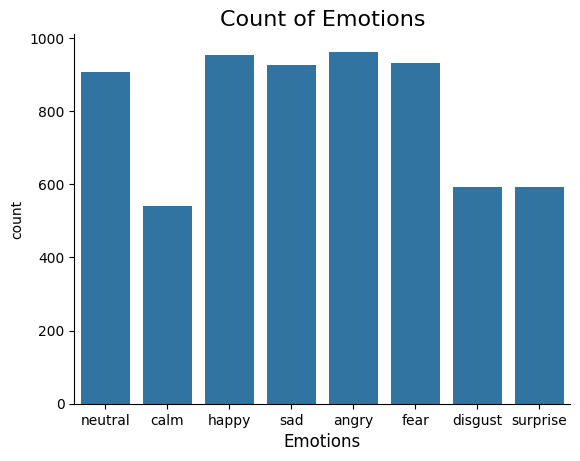

In [8]:
plt.title('Count of Emotions', size=16)
sns.countplot(x='Emotions', data=data_path)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

### Conclusion:

Classes are very imbalanced so we will have to use stratify method in train-test split

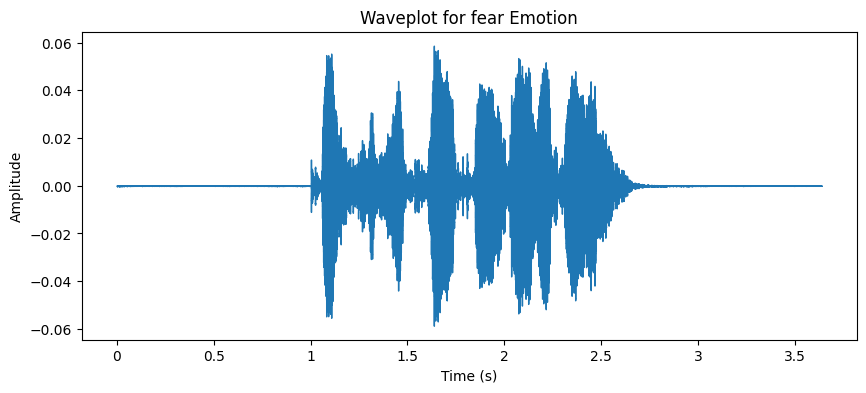

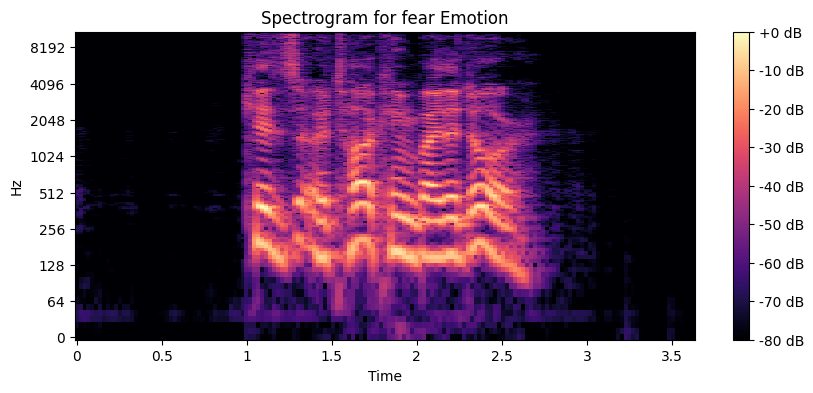

In [9]:
emotion = 'fear'
path = np.array(data_path.Path[data_path.Emotions == emotion])[1]
data, sampling_rate = librosa.load(path)

def create_waveplot(data, sampling_rate, emotion):
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(data, sr=sampling_rate)
    plt.title(f'Waveplot for {emotion} Emotion')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()

def create_spectrogram(data, sampling_rate, emotion):
    plt.figure(figsize=(10, 4))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
    librosa.display.specshow(D, sr=sampling_rate, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Spectrogram for {emotion} Emotion')
    plt.show()

create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

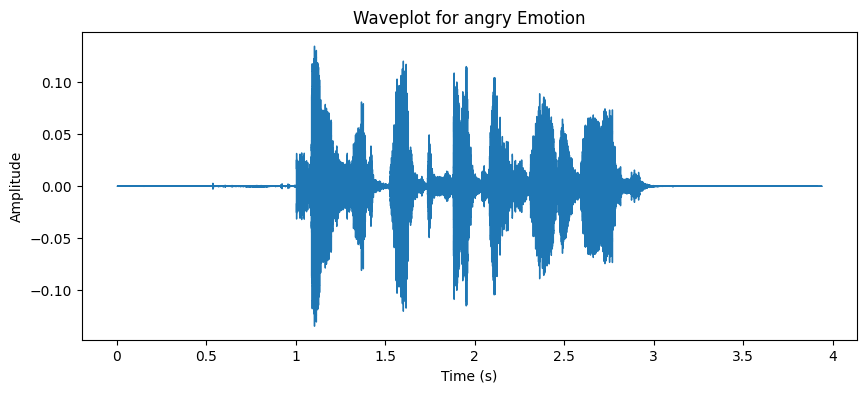

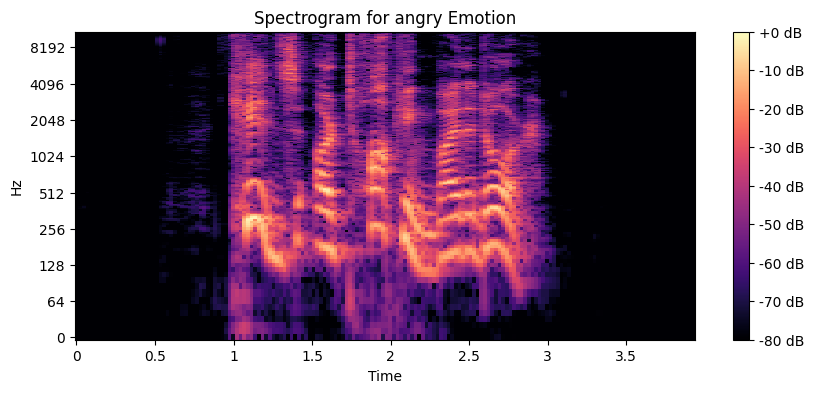

In [10]:
emotion = 'angry'
path = np.array(data_path.Path[data_path.Emotions == emotion])[1]
data, sampling_rate = librosa.load(path)

def create_waveplot(data, sampling_rate, emotion):
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(data, sr=sampling_rate)
    plt.title(f'Waveplot for {emotion} Emotion')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()

def create_spectrogram(data, sampling_rate, emotion):
    plt.figure(figsize=(10, 4))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
    librosa.display.specshow(D, sr=sampling_rate, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Spectrogram for {emotion} Emotion')
    plt.show()

create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

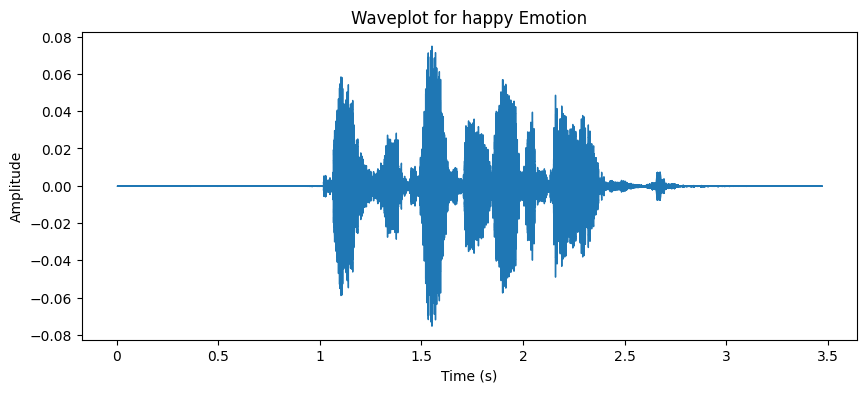

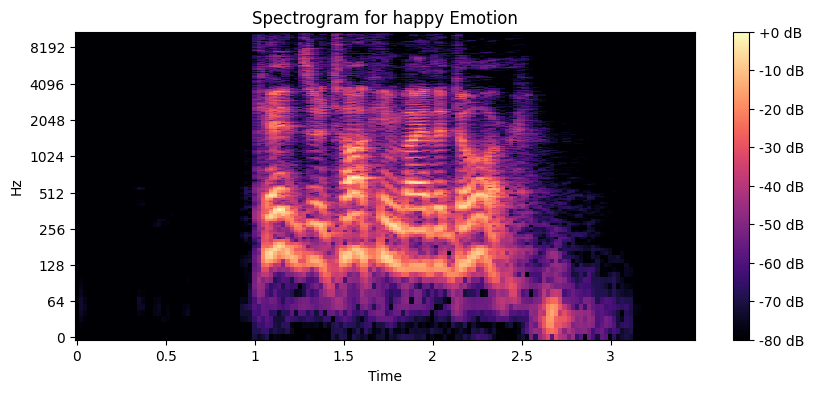

In [11]:
emotion = 'happy'
path = np.array(data_path.Path[data_path.Emotions == emotion])[1]
data, sampling_rate = librosa.load(path)

def create_waveplot(data, sampling_rate, emotion):
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(data, sr=sampling_rate)
    plt.title(f'Waveplot for {emotion} Emotion')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()

def create_spectrogram(data, sampling_rate, emotion):
    plt.figure(figsize=(10, 4))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
    librosa.display.specshow(D, sr=sampling_rate, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Spectrogram for {emotion} Emotion')
    plt.show()

create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

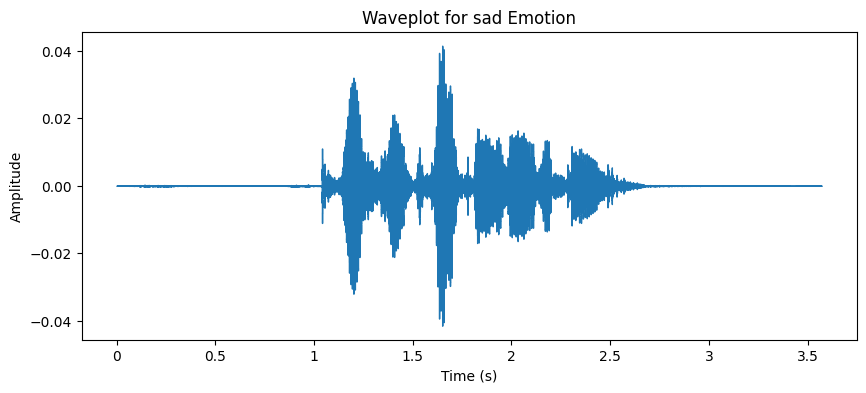

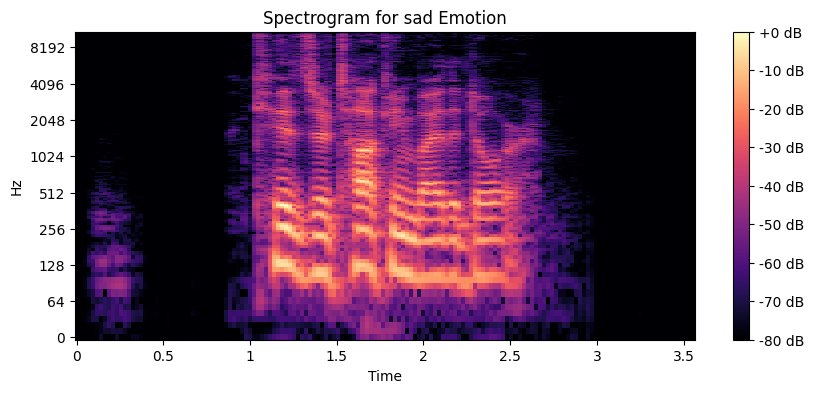

In [12]:
emotion = 'sad'
path = np.array(data_path.Path[data_path.Emotions == emotion])[1]
data, sampling_rate = librosa.load(path)

def create_waveplot(data, sampling_rate, emotion):
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(data, sr=sampling_rate)
    plt.title(f'Waveplot for {emotion} Emotion')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()

def create_spectrogram(data, sampling_rate, emotion):
    plt.figure(figsize=(10, 4))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
    librosa.display.specshow(D, sr=sampling_rate, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Spectrogram for {emotion} Emotion')
    plt.show()

create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

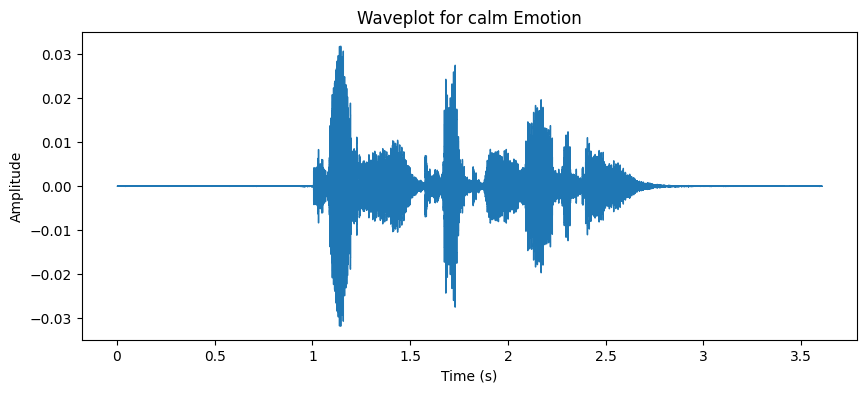

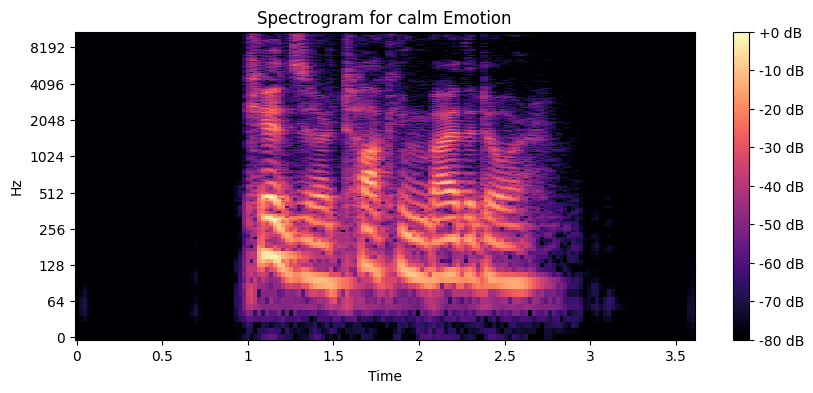

In [13]:
emotion = 'calm'
path = np.array(data_path.Path[data_path.Emotions == emotion])[1]
data, sampling_rate = librosa.load(path)

def create_waveplot(data, sampling_rate, emotion):
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(data, sr=sampling_rate)
    plt.title(f'Waveplot for {emotion} Emotion')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()

def create_spectrogram(data, sampling_rate, emotion):
    plt.figure(figsize=(10, 4))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
    librosa.display.specshow(D, sr=sampling_rate, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Spectrogram for {emotion} Emotion')
    plt.show()

create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

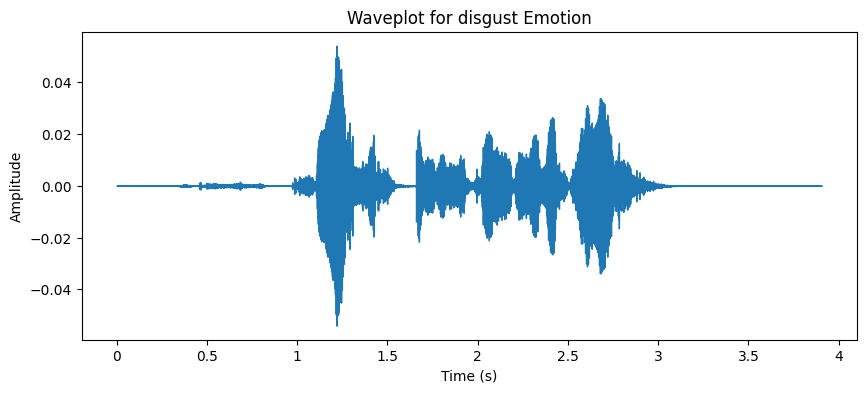

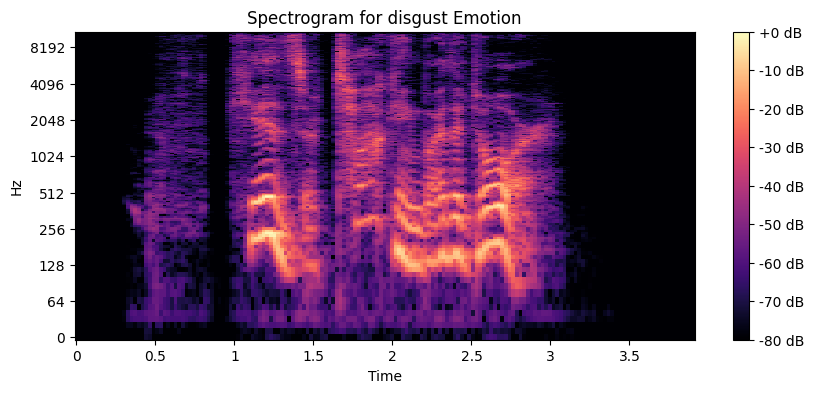

In [14]:
emotion = 'disgust'
path = np.array(data_path.Path[data_path.Emotions == emotion])[1]
data, sampling_rate = librosa.load(path)

def create_waveplot(data, sampling_rate, emotion):
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(data, sr=sampling_rate)
    plt.title(f'Waveplot for {emotion} Emotion')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()

def create_spectrogram(data, sampling_rate, emotion):
    plt.figure(figsize=(10, 4))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
    librosa.display.specshow(D, sr=sampling_rate, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Spectrogram for {emotion} Emotion')
    plt.show()

create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

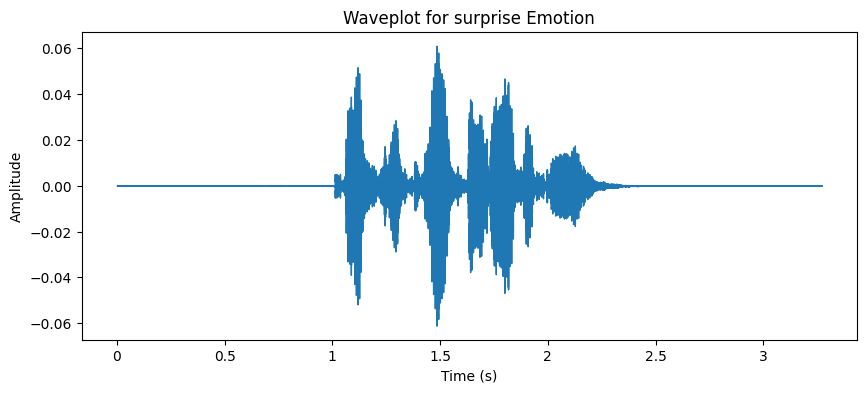

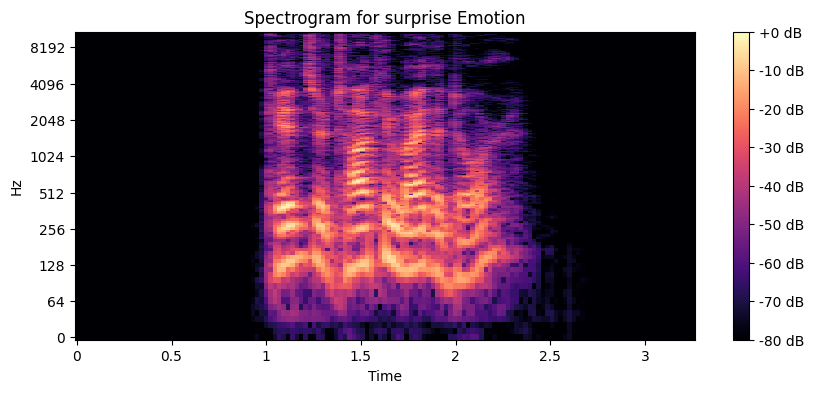

In [15]:
emotion = 'surprise'
path = np.array(data_path.Path[data_path.Emotions == emotion])[1]
data, sampling_rate = librosa.load(path)

def create_waveplot(data, sampling_rate, emotion):
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(data, sr=sampling_rate)
    plt.title(f'Waveplot for {emotion} Emotion')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()

def create_spectrogram(data, sampling_rate, emotion):
    plt.figure(figsize=(10, 4))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
    librosa.display.specshow(D, sr=sampling_rate, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Spectrogram for {emotion} Emotion')
    plt.show()

create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

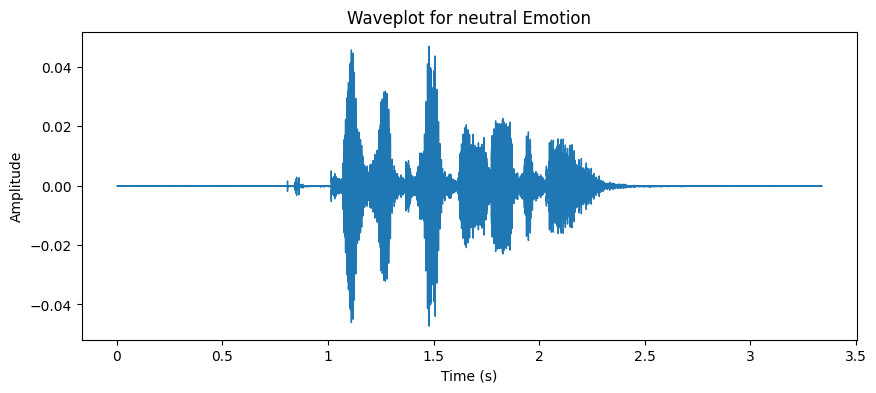

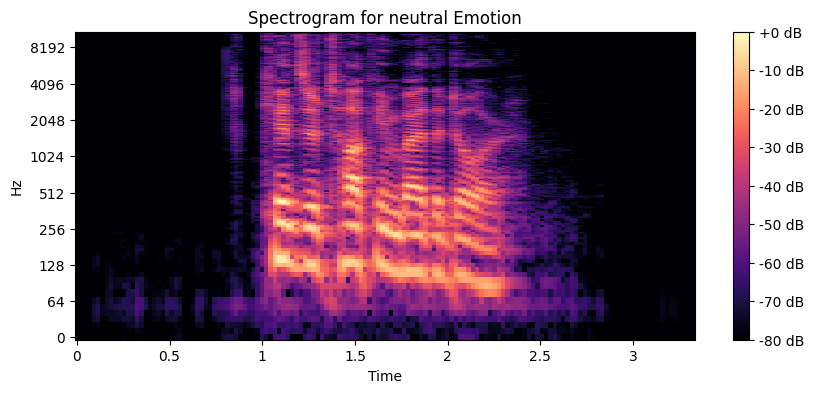

In [16]:
emotion = 'neutral'
path = np.array(data_path.Path[data_path.Emotions == emotion])[1]
data, sampling_rate = librosa.load(path)

def create_waveplot(data, sampling_rate, emotion):
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(data, sr=sampling_rate)
    plt.title(f'Waveplot for {emotion} Emotion')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()

def create_spectrogram(data, sampling_rate, emotion):
    plt.figure(figsize=(10, 4))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
    librosa.display.specshow(D, sr=sampling_rate, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Spectrogram for {emotion} Emotion')
    plt.show()

create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

## Feature Extraction

In [17]:
df = data_path.rename(columns={"Path": "speech", "Emotions": "label"})
df.head()

label                                             speech
0  neutral  /mnt/d/Datasets/SpeechEmotionRecognition/RAVDE...
1  neutral  /mnt/d/Datasets/SpeechEmotionRecognition/RAVDE...
2  neutral  /mnt/d/Datasets/SpeechEmotionRecognition/RAVDE...
3  neutral  /mnt/d/Datasets/SpeechEmotionRecognition/RAVDE...
4     calm  /mnt/d/Datasets/SpeechEmotionRecognition/RAVDE...

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6402 entries, 0 to 2161
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   6402 non-null   object
 1   speech  6402 non-null   object
dtypes: object(2)
memory usage: 150.0+ KB


In [19]:
# Define which emotions belong to each energy level
high_energy_emotions = ['angry', 'happy', 'fear', 'surprise']
low_energy_emotions = ['sad', 'calm', 'neutral', 'disgust']

# Create the new 'Energy' column based on the 'label'
def map_energy(label):
    if label in high_energy_emotions:
        return 'high'
    else:
        return 'low'

df['Energy'] = df['label'].apply(map_energy)

# Verify the result
print("DataFrame with the new 'Energy' column:")
print(df.head())

print("\nValue counts for the new column:")
print(df['Energy'].value_counts())

DataFrame with the new 'Energy' column:
     label                                             speech Energy
0  neutral  /mnt/d/Datasets/SpeechEmotionRecognition/RAVDE...    low
1  neutral  /mnt/d/Datasets/SpeechEmotionRecognition/RAVDE...    low
2  neutral  /mnt/d/Datasets/SpeechEmotionRecognition/RAVDE...    low
3  neutral  /mnt/d/Datasets/SpeechEmotionRecognition/RAVDE...    low
4     calm  /mnt/d/Datasets/SpeechEmotionRecognition/RAVDE...    low

Value counts for the new column:
Energy
high    3437
low     2965
Name: count, dtype: int64


In [20]:
import scipy.stats

def extract(file_path):
    try:
        y, sr = librosa.load(file_path, sr=None)
        features = []

        # MFCCs + deltas + delta-deltas
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfcc_delta = librosa.feature.delta(mfcc)
        mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
        mfcc_features = np.concatenate([mfcc, mfcc_delta, mfcc_delta2], axis=0)
        for row in mfcc_features:
            features.append(np.mean(row))
            features.append(np.std(row))
            features.append(scipy.stats.skew(row))
            features.append(scipy.stats.kurtosis(row))

        # Chroma
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        for row in chroma:
            features.append(np.mean(row))
            features.append(np.std(row))

        # Mel Spectrogram
        mel = librosa.feature.melspectrogram(y=y, sr=sr)
        mel_db = librosa.power_to_db(mel, ref=np.max)
        for row in mel_db:
            features.append(np.mean(row))
            features.append(np.std(row))

        # Spectral Contrast
        contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        for row in contrast:
            features.append(np.mean(row))
            features.append(np.std(row))

        # Tonnetz
        tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr)
        for row in tonnetz:
            features.append(np.mean(row))
            features.append(np.std(row))

        # Zero Crossing Rate
        zcr = librosa.feature.zero_crossing_rate(y)
        features.append(np.mean(zcr))
        features.append(np.std(zcr))

        # RMSE
        rmse = librosa.feature.rms(y=y)
        features.append(np.mean(rmse))
        features.append(np.std(rmse))

        return np.array(features)

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

In [21]:
from joblib import Parallel, delayed

df["features"] = Parallel(n_jobs=2)(delayed(extract)(path) for path in df["speech"])

df = df.dropna(subset=["features"])

print("Feature extraction completed!")
print(df.head())

/mnt/d/Programs/SGP-I/.venv/lib/python3.12/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=888
  warnings.warn(
/mnt/d/Programs/SGP-I/.venv/lib/python3.12/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=864
  warnings.warn(
/mnt/d/Programs/SGP-I/.venv/lib/python3.12/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=920
  warnings.warn(
/mnt/d/Programs/SGP-I/.venv/lib/python3.12/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=848
  warnings.warn(
/mnt/d/Programs/SGP-I/.venv/lib/python3.12/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=792
  warnings.warn(
/mnt/d/Programs/SGP-I/.venv/lib/python3.12/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal

Feature extraction completed!
     label                                             speech Energy  \
0  neutral  /mnt/d/Datasets/SpeechEmotionRecognition/RAVDE...    low   
1  neutral  /mnt/d/Datasets/SpeechEmotionRecognition/RAVDE...    low   
2  neutral  /mnt/d/Datasets/SpeechEmotionRecognition/RAVDE...    low   
3  neutral  /mnt/d/Datasets/SpeechEmotionRecognition/RAVDE...    low   
4     calm  /mnt/d/Datasets/SpeechEmotionRecognition/RAVDE...    low   

                                            features  
0  [-726.2172241210938, 157.850830078125, 0.57020...  
1  [-719.1282958984375, 159.3560028076172, 0.5393...  
2  [-714.9957275390625, 162.87423706054688, 0.585...  
3  [-710.9752807617188, 161.7758331298828, 0.6604...  
4  [-759.9217529296875, 162.98658752441406, 0.356...  


In [ ]:
# Export the extracted features and labels to reduce Code Re-execution everytime

extracted_features = np.array(df["features"].tolist())  # feature matrix
labels = df["label"].values  # raw labels or encoded labels as needed
Energy = df["Energy"].values  # energy labels

joblib.dump(extracted_features, "features.joblib")
joblib.dump(labels, "labels.joblib")

print(f"Files Saved Succesfully")

Files Saved Succesfully


In [28]:
from google.colab import files
files.download("/content/drive/MyDrive/SpeechEmotionRecoginition/labels.joblib")
files.download("/content/drive/MyDrive/SpeechEmotionRecoginition/features.joblib")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Model Definition, scaling, one-hot encoding

In [23]:
# Check GPU Availability

import tensorflow as tf
from tensorflow.python.platform import build_info as tf_build_info

print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

print("Is TensorFlow built with CUDA:", tf.test.is_built_with_cuda())
print("Num GPUs Available:", len(tf.config.list_physical_devices("GPU")))
print("Physical GPUs:", tf.config.list_physical_devices("GPU"))
print("CUDA version (from TF):", tf.sysconfig.get_build_info().get("cuda_version"))
print("cuDNN version (from TF):", tf.sysconfig.get_build_info().get("cudnn_version"))

print(tf_build_info.build_info)

2025-08-10 01:24:58.476371: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754789098.563692   24981 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754789098.589449   24981 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754789098.809693   24981 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754789098.809715   24981 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754789098.809716   24981 computation_placer.cc:177] computation placer alr

Num GPUs Available:  1
Is TensorFlow built with CUDA: True
Num GPUs Available: 1
Physical GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
CUDA version (from TF): 12.5.1
cuDNN version (from TF): 9
OrderedDict({'cpu_compiler': '/usr/lib/llvm-18/bin/clang', 'cuda_compute_capabilities': ['sm_60', 'sm_70', 'sm_80', 'sm_89', 'compute_90'], 'cuda_version': '12.5.1', 'cudnn_version': '9', 'is_cuda_build': True, 'is_rocm_build': False, 'is_tensorrt_build': False})


In [2]:
# Setup cell - Once you have everything upto features and labels exported, just run this cell so you can easily recreate everything the specific section of the model requires

# --- 1. Load Metadata DataFrame ---
# This CSV was created at the beginning and has the file paths and original labels.
df = pd.read_csv("data_path.csv")
df = df.rename(columns={"Path": "speech", "Emotions": "label"})

# --- 2. Create the 'Energy' Column ---
high_energy_emotions = ['angry', 'happy', 'fear', 'surprise']
df['Energy'] = df['label'].apply(
    lambda x: 'high' if x in high_energy_emotions else 'low'
)

# --- 3. Load Features and Labels ---
X = joblib.load("features.joblib")
y = joblib.load("labels.joblib")

# --- 4. The One and Only Train-Test Split ---
X_train, X_test, y_train_raw, y_test_raw = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# --- Verification ---
print("--- Setup Complete ---")
print("DataFrame Head:")
print(df.head())
print("\nArray Shapes:")
print(f"X_train shape: {X_train.shape}")
print(f"y_train_raw shape: {y_train_raw.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test_raw shape: {y_test_raw.shape}")

--- Setup Complete ---
DataFrame Head:
     label                                             speech Energy
0  neutral  /mnt/d/Datasets/SpeechEmotionRecognition/RAVDE...    low
1  neutral  /mnt/d/Datasets/SpeechEmotionRecognition/RAVDE...    low
2  neutral  /mnt/d/Datasets/SpeechEmotionRecognition/RAVDE...    low
3  neutral  /mnt/d/Datasets/SpeechEmotionRecognition/RAVDE...    low
4     calm  /mnt/d/Datasets/SpeechEmotionRecognition/RAVDE...    low

Array Shapes:
X_train shape: (5121, 466)
y_train_raw shape: (5121,)
X_test shape: (1281, 466)
y_test_raw shape: (1281,)


### Sequential LSTM - 8 class classification

In [13]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.utils import to_categorical

2025-08-10 00:46:31.018091: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754786791.469587   21219 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754786791.582409   21219 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754786792.781612   21219 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754786792.781642   21219 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754786792.781643   21219 computation_placer.cc:177] computation placer alr

In [ ]:
scaler = StandardScaler()

# Fit the scaler ONLY on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Use the same scaler to transform the test data
X_test_scaled = scaler.transform(X_test)

print(f"X train scaled Shape: {X_train_scaled.shape}")
print(f"X test scaled Shape: {X_test_scaled.shape}")

X train scaled Shape: (5122, 466)
X test scaled Shape: (1281, 466)


In [17]:
# Reshape the input features

X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

print(f"X train Reshaped Shape: {X_train_reshaped.shape}")
print(f"X test Reshaped Shape: {X_test_reshaped.shape}")

X train Reshaped Shape: (5122, 466, 1)
X test Reshaped Shape: (1281, 466, 1)


In [ ]:
from sklearn.utils import class_weight

class_labels = np.unique(y_train_raw)
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=class_labels,
    y=y_train_raw
)

# Create a dictionary mapping class indices to weights
class_weights = {i: weight for i, weight in enumerate(class_weights_array)}

print("Class Labels:", class_labels)
print("Calculated Weights:", class_weights_array)
print("\nClass Weight Dictionary for model.fit():\n")
for x in class_weights:
    print(f"Class {x}: {class_weights[x]}")

Class Labels: ['angry' 'calm' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']
Calculated Weights: [0.83257477 1.48206019 1.3507384  0.85939597 0.8413272  0.88310345
 0.86287062 1.3507384 ]

Class Weight Dictionary for model.fit():

Class 0: 0.8325747724317295
Class 1: 1.4820601851851851
Class 2: 1.3507383966244726
Class 3: 0.8593959731543624
Class 4: 0.8413272010512484
Class 5: 0.8831034482758621
Class 6: 0.8628706199460916
Class 7: 1.3507383966244726


In [ ]:
# Initialize OneHotEncoder
enc = OneHotEncoder(sparse_output=False)

# Fit encoder on train labels and transform train and test
y_train = enc.fit_transform(y_train_raw.reshape(-1, 1))
y_test = enc.transform(y_test_raw.reshape(-1, 1))

print(f"y train Shape: {y_train.shape}")
print(f"y test Shape: {y_test.shape}")

y train Shape: (5122, 8)
y test Shape: (1281, 8)


In [36]:
model = Sequential([
    LSTM(256, return_sequences=False, input_shape=(466,1)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(8, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

I0000 00:00:1754752465.310467     865 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2240 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5
/mnt/d/Programs/SGP-I/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 256)            │       264,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 305,864 (1.17 MB)

 Trainable params: 305,864 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

#### Training the Model

In [37]:
from keras.callbacks import EarlyStopping

# This callback will stop training if validation loss doesn't improve for 10 epochs
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

In [38]:
history = model.fit(
    X_train_reshaped,
    y_train,
    validation_data=(X_test_reshaped, y_test),
    epochs=500,  # Set a high number, EarlyStopping will find the best one
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stopping]  # Add the callback here
)

Epoch 1/500


I0000 00:00:1754752604.449226    6651 cuda_dnn.cc:529] Loaded cuDNN version 90300


161/161 ━━━━━━━━━━━━━━━━━━━━ 14s 51ms/step - accuracy: 0.2167 - loss: 1.9599 - val_accuracy: 0.2631 - val_loss: 1.8727
Epoch 2/500
161/161 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 0.2528 - loss: 1.8587 - val_accuracy: 0.3037 - val_loss: 1.8061
Epoch 3/500
161/161 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.2915 - loss: 1.7821 - val_accuracy: 0.3302 - val_loss: 1.7328
Epoch 4/500
161/161 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.3122 - loss: 1.7309 - val_accuracy: 0.3271 - val_loss: 1.6629
Epoch 5/500
161/161 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.3296 - loss: 1.6721 - val_accuracy: 0.3482 - val_loss: 1.6445
Epoch 6/500
161/161 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.3637 - loss: 1.6110 - val_accuracy: 0.3856 - val_loss: 1.5580
Epoch 7/500
161/161 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.3462 - loss: 1.6370 - val_accuracy: 0.3583 - val_loss: 1.6039
Epoch 8/500
161/161 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.3668 - loss: 1.5872 - val_accura

In [ ]:
# Assuming 'history' is the object returned by model.fit()
best_epoch = np.argmin(history.history['val_loss']) + 1 

print(f"The best epoch was: {best_epoch}")
print(f"The best validation loss was: {history.history['val_loss'][best_epoch-1]}")

The best epoch was: 31
The best validation loss was: 1.2121613025665283


#### Plotting the Result

In [42]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test_reshaped, y_test, verbose=0)

print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Loss: {loss:.4f}")

Test Accuracy: 54.18%
Test Loss: 1.2122


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


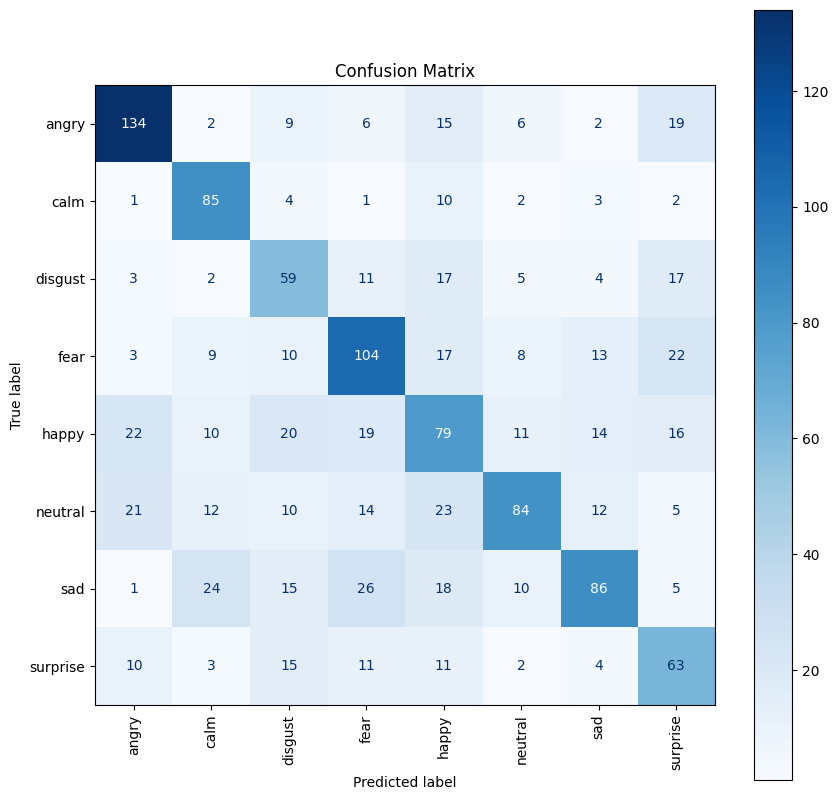

In [ ]:
# 1. Get model predictions on the test set
y_pred = model.predict(X_test_reshaped)

# 2. Convert predictions and true labels from one-hot format to class indices
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# 3. Get the actual class names from your encoder
class_names = enc.categories_[0]

# 4. Compute the confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# 5. Plot the confusion matrix for a clear visualization
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()

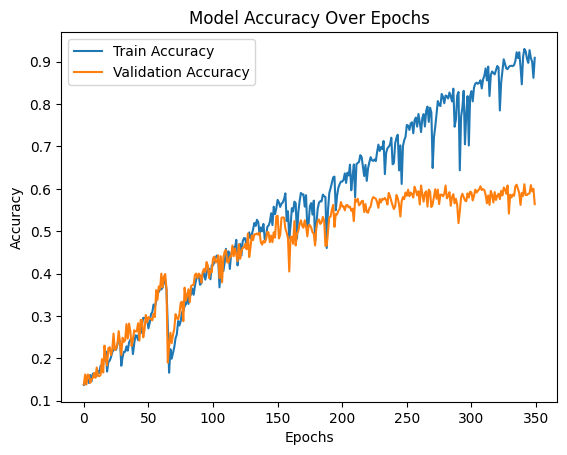

In [38]:
epochs = list(range(len(history.history['accuracy'])))
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, label='Train Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy Over Epochs')
plt.show()

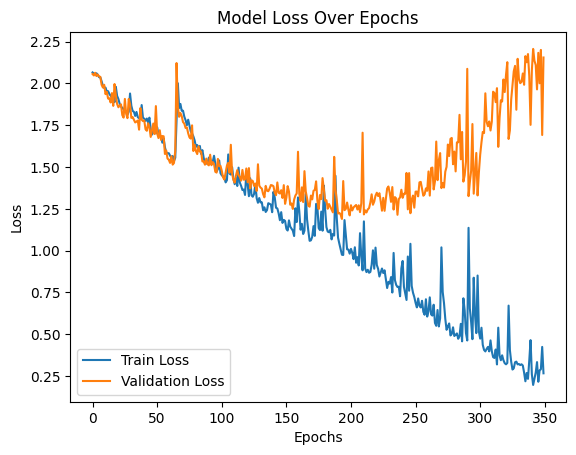

In [39]:
epochs = list(range(len(history.history['loss'])))
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss Over Epochs')

plt.show()

#### Prediction

In [ ]:
from google.colab import files
try:
  uploaded = files.upload()
  audio_file = list(uploaded.keys())[0]
  features = extract(audio_file)
  features = np.expand_dims(features, axis=0)
except:
  print("An Exception Occured")

In [55]:
audio_file = "audio.wav"
features = extract(audio_file)
features = np.expand_dims(features, axis=0)
print(f"Extracted features shape: {features.shape}")

features = features.reshape(features.shape[0], features.shape[1], 1)
print(f"Reshaped features shape: {features.shape}")

Extracted features shape: (1, 466)
Reshaped features shape: (1, 466, 1)


In [56]:
prediction = model.predict(features)
print("Model Prediction:", prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
Model Prediction: [[2.1855990e-04 2.9465646e-02 5.9155677e-03 1.4852305e-01 1.8503998e-01
  4.4785384e-02 5.8463877e-01 1.4129906e-03]]


In [57]:
predicted_class = np.argmax(prediction)
print("Predicted Class:", predicted_class)

Predicted Class: 6


In [ ]:
emotion_labels = [
    "😡angry😡",
    "😌calm😌",
    "🤮disgust🤮",
    "😨fearful😨",
    "😃happy😃",
    "😐neutral😐",
    "😟sad😟",
    "😯surprised😯"
]
predicted_emotion = emotion_labels[predicted_class]
print("Predicted Emotion:", predicted_emotion)

Predicted Emotion: 🤮disgust🤮


#### Save the model for deployment

In [60]:
import joblib
joblib.dump(enc, "label_encoder.pkl")
model.save("ser_model.keras")

In [ ]:
from google.colab import files
files.download("label_encoder.pkl")
files.download("ser_model.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Pipelined model

#### Component 1 - Binary classification Router model

High Energy vs Low Energy

In [23]:
# Load your pre-extracted features
X = joblib.load("features.joblib")

# Define your target variable
y_text = df['Energy'].values

# Encode text labels to numbers (e.g., 'high' -> 1, 'low' -> 0)
encoder = LabelEncoder()
y = encoder.fit_transform(y_text)

print(f"X Shape: {X.shape}")
print(f"y Shape: {y.shape}")

X Shape: (6402, 466)
y Shape: (6402,)


In [24]:
# X and y should be your loaded features and encoded energy labels
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # Good practice to maintain the original distribution
)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (5121, 466)
Testing set shape: (1281, 466)


In [25]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled successfully.")

Features scaled successfully.


In [26]:
import lightgbm as lgb

# Initialize and train the model
router_model = lgb.LGBMClassifier(random_state=42)
router_model.fit(X_train_scaled, y_train)

print("Router model trained successfully!")

[LightGBM] [Info] Number of positive: 2372, number of negative: 2749
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028892 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 118830
[LightGBM] [Info] Number of data points in the train set: 5121, number of used features: 466
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.463191 -> initscore=-0.147504
[LightGBM] [Info] Start training from score -0.147504
Router model trained successfully!


In [27]:
# Make predictions on the test set
y_pred = router_model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Router Model Test Accuracy: {accuracy * 100:.2f}%\n")

# Get a detailed report
# You'll need the original LabelEncoder ('encoder') to see the class names
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=encoder.classes_))

Router Model Test Accuracy: 86.03%

Classification Report:
              precision    recall  f1-score   support

        high       0.85      0.89      0.87       688
         low       0.87      0.82      0.85       593

    accuracy                           0.86      1281
   macro avg       0.86      0.86      0.86      1281
weighted avg       0.86      0.86      0.86      1281



/mnt/d/Programs/SGP-I/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


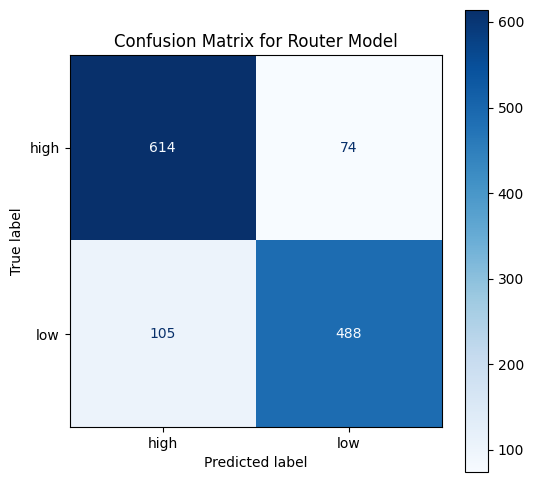

In [28]:
# encoder is the LabelEncoder you created for the 'Energy' labels.

# Get the class names (e.g., ['high', 'low']) from the encoder
class_names = encoder.classes_

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix for a clear visualization
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Router Model')
plt.show()

#### Component 2 - Specialist Model

In [13]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dropout, LSTM, Dense
from keras.callbacks import EarlyStopping
from sklearn.utils import class_weight

##### High Energy Model

In [3]:
high_energy_emotions = ['angry', 'happy', 'fear', 'surprise']

# --- Create TRAINING subset from the main training set ---
train_df = pd.DataFrame({'label': y_train_raw})
high_energy_train_indices = train_df['label'].isin(high_energy_emotions)

X_train_h = X_train[high_energy_train_indices]
y_train_h_text = y_train_raw[high_energy_train_indices]

# --- Create TESTING subset from the main testing set ---
test_df = pd.DataFrame({'label': y_test_raw})
high_energy_test_indices = test_df['label'].isin(high_energy_emotions)

X_test_h = X_test[high_energy_test_indices]
y_test_h_text = y_test_raw[high_energy_test_indices]

print(f"Shape of high-energy TRAINING features: {X_train_h.shape}")
print(f"Shape of high-energy TESTING features: {X_test_h.shape}")

Shape of high-energy TRAINING features: (2749, 466)
Shape of high-energy TESTING features: (688, 466)


In [4]:
# --- Encode Labels (using the text labels from the correct subsets) ---
le_high = LabelEncoder()
y_train_h = le_high.fit_transform(y_train_h_text)
y_test_h = le_high.transform(y_test_h_text)
print("Label encoding mapping:")
for i, label in enumerate(le_high.classes_):
    print(f"{i}: {label}")

Label encoding mapping:
0: angry
1: fear
2: happy
3: surprise


In [5]:
# --- Scale and Reshape Features ---
scaler_h = StandardScaler()
X_train_h_scaled = scaler_h.fit_transform(X_train_h)
X_test_h_scaled = scaler_h.transform(X_test_h)

X_train_h_reshaped = X_train_h_scaled.reshape(X_train_h_scaled.shape[0], X_train_h_scaled.shape[1], 1)
X_test_h_reshaped = X_test_h_scaled.reshape(X_test_h_scaled.shape[0], X_test_h_scaled.shape[1], 1)

print("High-energy features scaled and reshaped.")
print(f"X_train_h_reshaped shape: {X_train_h_reshaped.shape}")
print(f"X_test_h_reshaped shape: {X_test_h_reshaped.shape}")

High-energy features scaled and reshaped.
X_train_h_reshaped shape: (2749, 466, 1)
X_test_h_reshaped shape: (688, 466, 1)


In [6]:
# --- One-Hot Encode Final Labels ---
ohe_h = OneHotEncoder(sparse_output=False)
y_train_h_ohe = ohe_h.fit_transform(y_train_h.reshape(-1, 1))
y_test_h_ohe = ohe_h.transform(y_test_h.reshape(-1, 1))

print("High-energy data correctly prepared for modeling.")
print(f"Shape of one-hot encoded training labels: {y_train_h_ohe.shape}")
print(f"Shape of one-hot encoded testing labels: {y_test_h_ohe.shape}")

High-energy data correctly prepared for modeling.
Shape of one-hot encoded training labels: (2749, 4)
Shape of one-hot encoded testing labels: (688, 4)


In [14]:
# --- Calculate Class Weights ---
class_weights_h = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_h),
    y=y_train_h
)
class_weights_h_dict = {i: weight for i, weight in enumerate(class_weights_h)}

# --- Define the Model ---
specialist_high = Sequential([
    Conv1D(128, kernel_size=5, activation='relu', input_shape=(X_train_h_reshaped.shape[1], 1)),
    MaxPooling1D(2),
    Dropout(0.2),
    LSTM(256, return_sequences=False),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(4, activation='softmax')
])

# --- Compile and Train ---
specialist_high.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_high = specialist_high.fit(
    X_train_h_reshaped,
    y_train_h_ohe,
    validation_data=(X_test_h_reshaped, y_test_h_ohe), # Using the correct validation set
    epochs=500,
    class_weight=class_weights_h_dict,
    callbacks=[early_stopping]
)

Epoch 1/500


/mnt/d/Programs/SGP-I/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.3601 - loss: 1.3049 - val_accuracy: 0.3968 - val_loss: 1.2529
Epoch 2/500
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.4569 - loss: 1.1481 - val_accuracy: 0.5073 - val_loss: 1.0648
Epoch 3/500
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.5118 - loss: 1.0578 - val_accuracy: 0.5233 - val_loss: 1.0021
Epoch 4/500
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.5336 - loss: 1.0091 - val_accuracy: 0.5552 - val_loss: 0.9792
Epoch 5/500
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.5777 - loss: 0.9642 - val_accuracy: 0.5988 - val_loss: 0.9255
Epoch 6/500
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.5817 - loss: 0.9398 - val_accuracy: 0.5552 - val_loss: 0.9503
Epoch 7/500
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.6086 - loss: 0.9003 - val_accuracy: 0.6119 - val_loss: 0.8869
Epoch 8/500
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.6108 - loss: 0.8804 - val_accuracy: 0.5858 - val_l


The best epoch was: 20
The best validation loss achieved was: 0.7234

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Classification Report for High-Energy Specialist Model:
              precision    recall  f1-score   support

       angry       0.80      0.71      0.75       193
        fear       0.72      0.72      0.72       186
       happy       0.66      0.68      0.67       191
    surprise       0.59      0.67      0.63       118

    accuracy                           0.70       688
   macro avg       0.69      0.70      0.69       688
weighted avg       0.70      0.70      0.70       688



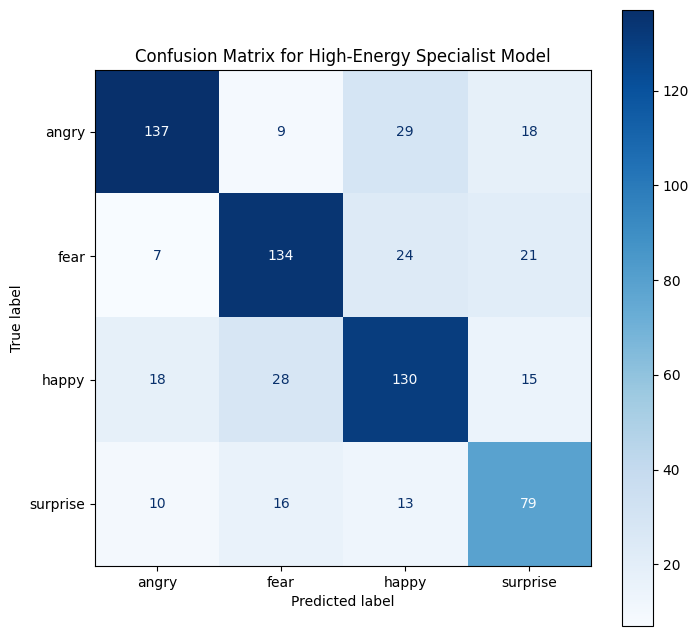

In [15]:
# --- Find Best Epoch ---
best_epoch_h = np.argmin(history_high.history['val_loss']) + 1
best_val_loss_h = np.min(history_high.history['val_loss'])
print(f"\nThe best epoch was: {best_epoch_h}")
print(f"The best validation loss achieved was: {best_val_loss_h:.4f}\n")

# --- Generate Predictions & Reports ---
y_pred_h = specialist_high.predict(X_test_h_reshaped)
y_pred_h_classes = np.argmax(y_pred_h, axis=1)
y_test_h_classes = np.argmax(y_test_h_ohe, axis=1)

high_energy_class_names = le_high.classes_
print("Classification Report for High-Energy Specialist Model:")
print(classification_report(y_test_h_classes, y_pred_h_classes, target_names=high_energy_class_names))

cm_high = confusion_matrix(y_test_h_classes, y_pred_h_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_high, display_labels=high_energy_class_names)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.title('Confusion Matrix for High-Energy Specialist Model')
plt.show()

##### Low Energy Model

In [16]:
low_energy_emotions = ['sad', 'calm', 'neutral', 'disgust']

# --- Create TRAINING subset from the main training set ---
train_df = pd.DataFrame({'label': y_train_raw})
low_energy_train_indices = train_df['label'].isin(low_energy_emotions)

X_train_l = X_train[low_energy_train_indices]
y_train_l_text = y_train_raw[low_energy_train_indices]

# --- Create TESTING subset from the main testing set ---
test_df = pd.DataFrame({'label': y_test_raw})
low_energy_test_indices = test_df['label'].isin(low_energy_emotions)

X_test_l = X_test[low_energy_test_indices]
y_test_l_text = y_test_raw[low_energy_test_indices]

print(f"Shape of low-energy TRAINING features: {X_train_l.shape}")
print(f"Shape of low-energy TESTING features: {X_test_l.shape}")

Shape of low-energy TRAINING features: (2372, 466)
Shape of low-energy TESTING features: (593, 466)


In [17]:
# --- Encode Labels (using the text labels from the correct subsets) ---
le_low = LabelEncoder()
y_train_l = le_low.fit_transform(y_train_l_text)
y_test_l = le_low.transform(y_test_l_text)
print("Label encoding mapping:")
for i, label in enumerate(le_low.classes_):
    print(f"{i}: {label}")

Label encoding mapping:
0: calm
1: disgust
2: neutral
3: sad


In [18]:
# --- Scale and Reshape Features ---
scaler_l = StandardScaler()
X_train_l_scaled = scaler_l.fit_transform(X_train_l)
X_test_l_scaled = scaler_l.transform(X_test_l)

X_train_l_reshaped = X_train_l_scaled.reshape(X_train_l_scaled.shape[0], X_train_l_scaled.shape[1], 1)
X_test_l_reshaped = X_test_l_scaled.reshape(X_test_l_scaled.shape[0], X_test_l_scaled.shape[1], 1)

print("Low-energy features scaled and reshaped.")
print(f"X_train_l_reshaped shape: {X_train_l_reshaped.shape}")
print(f"X_test_l_reshaped shape: {X_test_l_reshaped.shape}")

Low-energy features scaled and reshaped.
X_train_l_reshaped shape: (2372, 466, 1)
X_test_l_reshaped shape: (593, 466, 1)


In [19]:
# --- One-Hot Encode Final Labels ---
ohe_l = OneHotEncoder(sparse_output=False)
y_train_l_ohe = ohe_l.fit_transform(y_train_l.reshape(-1, 1))
y_test_l_ohe = ohe_l.transform(y_test_l.reshape(-1, 1))

print("Low-energy data correctly prepared for modeling.")
print(f"Shape of one-hot encoded training labels: {y_train_l_ohe.shape}")
print(f"Shape of one-hot encoded testing labels: {y_test_l_ohe.shape}")

Low-energy data correctly prepared for modeling.
Shape of one-hot encoded training labels: (2372, 4)
Shape of one-hot encoded testing labels: (593, 4)


In [20]:
# --- Calculate Class Weights ---
class_weights_l = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_l),
    y=y_train_l
)
class_weights_l_dict = {i: weight for i, weight in enumerate(class_weights_l)}

# --- Define the Model ---
specialist_low = Sequential([
    Conv1D(128, kernel_size=5, activation='relu', input_shape=(X_train_l_reshaped.shape[1], 1)),
    MaxPooling1D(2),
    Dropout(0.2),
    LSTM(256, return_sequences=False),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(4, activation='softmax')
])

# --- Compile and Train ---
specialist_low.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_low = specialist_low.fit(
    X_train_l_reshaped,
    y_train_l_ohe,
    validation_data=(X_test_l_reshaped, y_test_l_ohe),
    epochs=500,
    class_weight=class_weights_l_dict,
    callbacks=[early_stopping]
)

Epoch 1/500


/mnt/d/Programs/SGP-I/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.3419 - loss: 1.3172 - val_accuracy: 0.4165 - val_loss: 1.2558
Epoch 2/500
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.3917 - loss: 1.2089 - val_accuracy: 0.4755 - val_loss: 1.1891
Epoch 3/500
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.4414 - loss: 1.1519 - val_accuracy: 0.4621 - val_loss: 1.1333
Epoch 4/500
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.4747 - loss: 1.0684 - val_accuracy: 0.5379 - val_loss: 1.0623
Epoch 5/500
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.5143 - loss: 1.0103 - val_accuracy: 0.5599 - val_loss: 0.9841
Epoch 6/500
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.5464 - loss: 0.9616 - val_accuracy: 0.5245 - val_loss: 1.0067
Epoch 7/500
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.5675 - loss: 0.9220 - val_accuracy: 0.5666 - val_loss: 0.9761
Epoch 8/500
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.5831 - loss: 0.9009 - val_accuracy: 0.5734 - val_l


The best epoch was: 24
The best validation loss achieved was: 0.6957

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Classification Report for Low-Energy Specialist Model:
              precision    recall  f1-score   support

        calm       0.72      0.85      0.78       108
     disgust       0.60      0.77      0.67       118
     neutral       0.71      0.67      0.69       181
         sad       0.76      0.59      0.66       186

    accuracy                           0.70       593
   macro avg       0.70      0.72      0.70       593
weighted avg       0.71      0.70      0.70       593



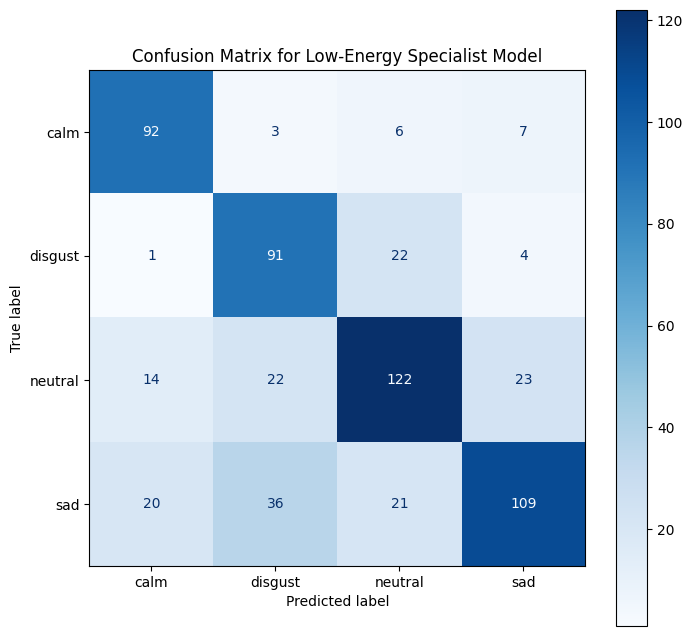

In [21]:
# --- Find Best Epoch ---
best_epoch_l = np.argmin(history_low.history['val_loss']) + 1
best_val_loss_l = np.min(history_low.history['val_loss'])
print(f"\nThe best epoch was: {best_epoch_l}")
print(f"The best validation loss achieved was: {best_val_loss_l:.4f}\n")

# --- Generate Predictions & Reports ---
y_pred_l = specialist_low.predict(X_test_l_reshaped)
y_pred_l_classes = np.argmax(y_pred_l, axis=1)
y_test_l_classes = np.argmax(y_test_l_ohe, axis=1)

low_energy_class_names = le_low.classes_
print("Classification Report for Low-Energy Specialist Model:")
print(classification_report(y_test_l_classes, y_pred_l_classes, target_names=low_energy_class_names))

cm_low = confusion_matrix(y_test_l_classes, y_pred_l_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_low, display_labels=low_energy_class_names)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Low-Energy Specialist Model')
plt.show()

#### Save the model, encoders and scalers

In [ ]:
# Define the path where you want to save the models
save_path = "../backend/export/"

# Create the directory if it doesn't already exist
os.makedirs(save_path, exist_ok=True)

# Now, you can safely save your files
print(f"Saving files to '{save_path}' directory...")

# Save the router model and its objects
joblib.dump(router_model, os.path.join(save_path, "router_model.joblib"))
joblib.dump(scaler, os.path.join(save_path, "router_scaler.joblib"))
joblib.dump(encoder, os.path.join(save_path, "router_encoder.joblib"))

# Save the high-energy specialist and its objects
specialist_high.save(os.path.join(save_path, "specialist_high.keras"))
joblib.dump(scaler_h, os.path.join(save_path, "scaler_h.joblib"))
joblib.dump(le_high, os.path.join(save_path, "le_high.joblib"))

# Save the low-energy specialist and its objects
specialist_low.save(os.path.join(save_path, "specialist_low.keras"))
joblib.dump(scaler_l, os.path.join(save_path, "scaler_l.joblib"))
joblib.dump(le_low, os.path.join(save_path, "le_low.joblib"))

print("\nAll final models and objects saved successfully!")

Saving files to 'export/' directory...

All final models and objects saved successfully!
